In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files

In [43]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [44]:
# Cố định seed
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [45]:
base_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data'

In [46]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [47]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [48]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 14 lớp (sinh viên): ['Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong train: 482
Phân bố số lượng ảnh theo lớp: {'Anh': 44, 'ATuan': 56, 'banAnh': 34, 'Binh': 32, 'Duc': 29, 'Hoang': 38, 'Hung': 30, 'KAnh': 48, 'Lan': 19, 'Long': 35, 'NAnh': 22, 'Nhung': 33, 'Son': 33, 'TAnh': 29}

Thư mục validation có 14 lớp (sinh viên): ['Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong validation: 147
Phân bố số lượng ảnh theo lớp: {'Anh': 13, 'ATuan': 16, 'banAnh': 11, 'Binh': 8, 'Duc': 8, 'Hoang': 12, 'Hung': 10, 'KAnh': 15, 'Lan': 6, 'Long': 12, 'NAnh': 8, 'Nhung': 9, 'Son': 10, 'TAnh': 9}

Thư mục test có 14 lớp (sinh viên): ['Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong test: 97
Phân bố số lượng ảnh theo lớp: {'Anh': 9, 'ATuan': 10, 

In [49]:
# Cấu hình tham số
IMG_SIZE = 224  # Kích thước đầu vào cho MobileNetV2
BATCH_SIZE = 32
EPOCHS = 30

In [50]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 14
Các lớp: ['ATuan', 'Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [51]:
# Data augmentation cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,            # Tăng mức zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [52]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 482 images belonging to 14 classes.
Found 147 images belonging to 14 classes.
Found 97 images belonging to 14 classes.


In [53]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [54]:
images, labels = next(train_generator)

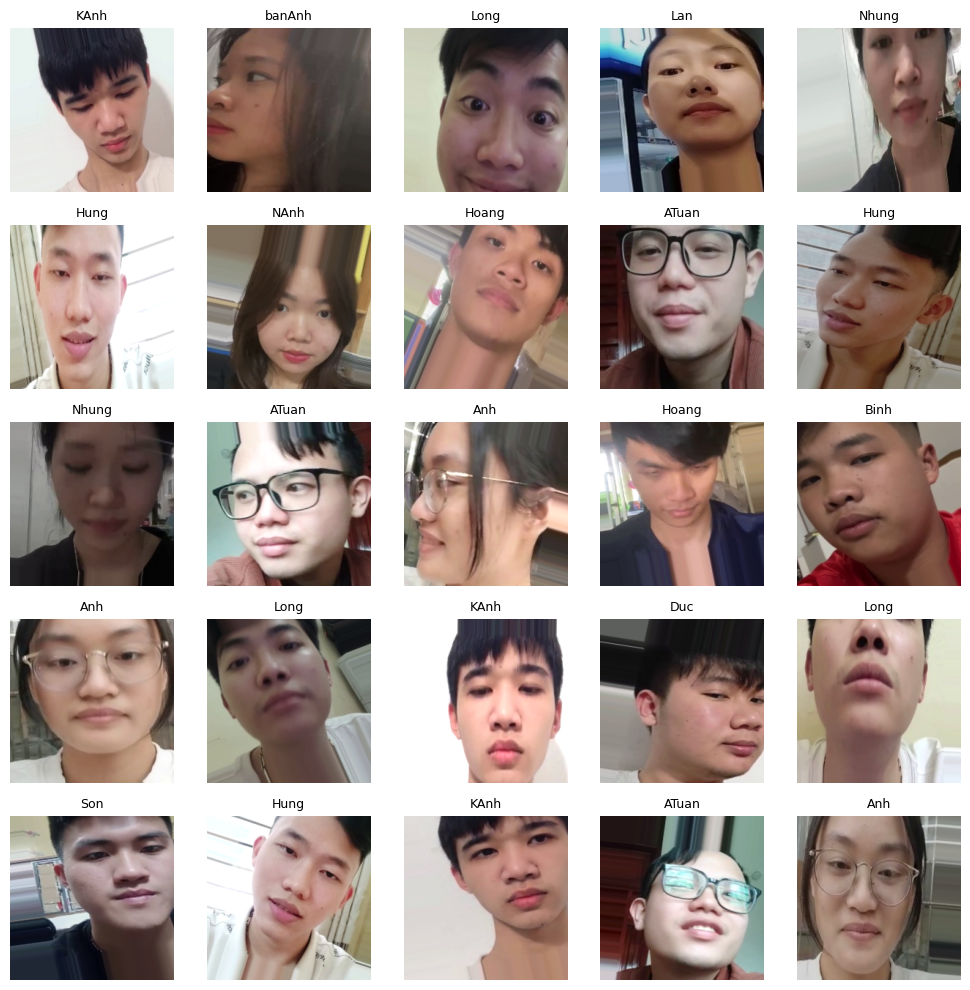

In [55]:
show_batch(images, labels, train_generator.class_indices)

In [56]:
def build_model(num_classes):
    # Tải MobileNetV2 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp của mô hình cơ sở
    for layer in base_model.layers:
        layer.trainable = False

    # Thêm các lớp mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Lớp output cho nhận diện khuôn mặt (số lượng lớp = số sinh viên)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

In [57]:
# Tạo mô hình
model, base_model = build_model(num_classes)

In [58]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 4,106,830 (15.67 MB)

 Trainable params: 1,846,286 (7.04 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [60]:
# def find_optimal_lr(model, train_generator, start_lr=1e-7, end_lr=1, num_iter=100, diverge_factor=5):
#     # Lưu trọng số ban đầu
#     initial_weights = model.get_weights()

#     # Danh sách lưu learning rates và losses
#     lrs = []
#     losses = []

#     # Tính hệ số nhân
#     lr_mult = (end_lr / start_lr) ** (1 / num_iter)
#     lr = start_lr

#     # Theo dõi loss tốt nhất để early stopping
#     best_loss = float('inf')

#     # Lặp qua các iterations
#     for i in range(num_iter):
#         # Tạo optimizer mới với learning rate hiện tại
#         optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#         # Compile model với optimizer mới
#         model.compile(
#             optimizer=optimizer,
#             loss='categorical_crossentropy',
#             metrics=['accuracy']
#         )

#         # Lấy một batch dữ liệu
#         try:
#             x_batch, y_batch = next(train_generator)
#         except StopIteration:
#             train_generator.reset()
#             x_batch, y_batch = next(train_generator)

#         # Huấn luyện một batch
#         history = model.train_on_batch(x_batch, y_batch, return_dict=True)
#         loss = history['loss']

#         # Lưu learning rate và loss
#         lrs.append(lr)
#         losses.append(loss)

#         # In trạng thái
#         if i % 10 == 0:
#             print(f"Iteration {i}/{num_iter}, LR: {lr:.8f}, Loss: {loss:.6f}")

#         # Early stopping khi loss tăng quá cao
#         if loss < best_loss:
#             best_loss = loss
#         elif loss > best_loss * diverge_factor:
#             print(f"Early stopping tại iteration {i} - Loss tăng quá cao ({loss:.6f} > {best_loss:.6f}*{diverge_factor})")
#             break

#         # Tăng learning rate
#         lr *= lr_mult

#     # Khôi phục trọng số ban đầu
#     model.set_weights(initial_weights)

#     # Vẽ biểu đồ
#     plt.figure(figsize=(12, 6))
#     plt.plot(lrs, losses)
#     plt.xscale('log')
#     plt.xlabel('Learning Rate')
#     plt.ylabel('Loss')
#     plt.title('Learning Rate Finder')
#     plt.grid(True, which="both", ls="--")
#     plt.show()

#     # Tìm learning rate tối ưu
#     # Làm mịn losses
#     window_size = 5
#     smoothed_losses = []

#     for i in range(len(losses)):
#         if i < window_size // 2:
#             smoothed_losses.append(losses[i])
#         elif i >= len(losses) - window_size // 2:
#             smoothed_losses.append(losses[i])
#         else:
#             smoothed_losses.append(np.mean(losses[i - window_size // 2:i + window_size // 2 + 1]))

#     # Tính gradient
#     gradients = np.gradient(smoothed_losses)

#     # Tìm vị trí có độ dốc âm lớn nhất
#     # Bỏ qua 10% đầu và 10% cuối
#     start_idx = int(len(gradients) * 0.1)
#     end_idx = int(len(gradients) * 0.9)

#     min_grad_idx = start_idx + np.argmin(gradients[start_idx:end_idx])

#     # Lấy learning rate tại vị trí đó, chia 10 để an toàn
#     optimal_lr = lrs[min_grad_idx] / 10
#     print(f"Learning rate tối ưu: {optimal_lr:.8f}")

#     return optimal_lr

In [61]:
# # Tìm learning rate tối ưu
# optimal_lr = find_optimal_lr(model, train_generator)

# # Compile model với learning rate tối ưu
# model.compile(
#     optimizer=Adam(learning_rate=optimal_lr),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# print(f"Đã biên dịch model với learning rate tối ưu: {optimal_lr:.8f}")

## Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [62]:
# Thư mục để lưu mô hình
model_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models'
os.makedirs(model_dir, exist_ok=True)

In [63]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [64]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [65]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [66]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.3195 - loss: 2.6820
Epoch 1: val_accuracy improved from -inf to 0.67188, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3282 - loss: 2.6358 - val_accuracy: 0.6719 - val_loss: 1.3199 - learning_rate: 0.0010
Epoch 2/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6875 - loss: 1.0957

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.67188 to 0.67969, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.6875 - loss: 1.0957 - val_accuracy: 0.6797 - val_loss: 1.2795 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7866 - loss: 0.6798
Epoch 3: val_accuracy improved from 0.67969 to 0.83594, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7888 - loss: 0.6740 - val_accuracy: 0.8359 - val_loss: 0.7092 - learning_rate: 0.0010
Epoch 4/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8438 - loss: 0.6619
Epoch 4: val_accuracy improved from 0.83594 to 0.85156, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.8438 - loss: 0.6619 - val_accuracy: 0.8516 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8700 - loss: 0.4641
Epoch 5: val_accuracy improved from 0.85156 to 0.88281, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8707 - loss: 0.4596 - val_accuracy: 0.8828 - val_loss: 0.4960 - learning_rate: 0.0010
Epoch 6/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8438 - loss: 0.4311
Epoch 6: val_accuracy improved from 0.88281 to 0.89844, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.8438 - loss: 0.4311 - val_accuracy: 0.8984 - val_loss: 0.4820 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9191 - loss: 0.2607
Epoch 7: val_accuracy improved from 0.89844 to 0.92969, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9187 - loss: 0.2615 - val_accuracy: 0.9297 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 8/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9375 - loss: 0.2093
Epoch 8: val_accuracy did not improve from 0.92969
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9375 - loss: 0.2093 - val_accuracy: 0.9297 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9102 - loss: 0.2739
Epoch 9: val_accuracy did not improve from 0.92969
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9100 - loss: 0.2752 - val_accuracy: 0.9141 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 10/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0428
Epoch 10: val_accuracy improved from 0.92969 to 0.93750, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 1.0000 - loss: 0.0428 - val_accuracy: 0.9375 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9180 - loss: 0.2303
Epoch 11: val_accuracy improved from 0.93750 to 0.96094, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9167 - loss: 0.2344 - val_accuracy: 0.9609 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 12/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9062 - loss: 0.3546
Epoch 12: val_accuracy did not improve from 0.96094
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9062 - loss: 0.3546 - val_accuracy: 0.9609 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9258 - loss: 0.2714
Epoch 13: val_accuracy did not improve from 0.96094
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9250 - loss: 0.2753 - val_accuracy: 0.9453 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 14/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9688 - loss: 0.2543
Epoch 14: val_accuracy did not improve from 0.96094
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.9688 - loss: 0.2543 - val_accuracy: 0.9375 - val_loss: 0.1562 - learning_rate: 0.0010
Epoch 15/30
15/15 ━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 653ms/step - accuracy: 0.9062 - loss: 0.2556 - val_accuracy: 0.9688 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 17/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9329 - loss: 0.2472
Epoch 17: val_accuracy improved from 0.96875 to 0.99219, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage1.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9332 - loss: 0.2455 - val_accuracy: 0.9922 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 18/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0166
Epoch 18: val_accuracy did not improve from 0.99219
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.9922 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 19/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9483 - loss: 0.1658
Epoch 19: val_accuracy did not improve from 0.99219
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9482 - loss: 0.1655 - val_accuracy: 0.9766 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 20/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9062 - loss: 0.3760
Epoch 20: val_accuracy did not improve from 0.99219

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.9062 - loss: 0.3760 - val_accurac

## Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [67]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-40]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-40:]:  # Mở khóa 40 lớp cuối
    layer.trainable = True

In [68]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [70]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    verbose=1
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.7507 - loss: 0.8088
Epoch 1: val_accuracy improved from -inf to 0.97656, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250410-172710/best_model_stage2.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7537 - loss: 0.7974 - val_accuracy: 0.9766 - val_loss: 0.0770 - learning_rate: 1.0000e-04
Epoch 2/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8438 - loss: 0.7171
Epoch 2: val_accuracy did not improve from 0.97656
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.8438 - loss: 0.7171 - val_accuracy: 0.9766 - val_loss: 0.0823 - learning_rate: 1.0000e-04
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8999 - loss: 0.3826
Epoch 3: val_accuracy did not improve from 0.97656
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 982ms/step - accuracy: 0.9004 - loss: 0.3806 - val_accuracy: 0.9766 - val_loss: 0.1048 - learning_rate: 1.0000e-04
Epoch 4/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9688 - loss: 0.1142
Epoch 4: val_accuracy did not improve from 0.97656

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9688 - loss: 0.1142 - val

15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9452 - loss: 0.1458 - val_accuracy: 0.9844 - val_loss: 0.0823 - learning_rate: 5.0000e-05
Epoch 6/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9375 - loss: 0.0954
Epoch 6: val_accuracy did not improve from 0.98438
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9375 - loss: 0.0954 - val_accuracy: 0.9844 - val_loss: 0.0814 - learning_rate: 5.0000e-05
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9486 - loss: 0.2339
Epoch 7: val_accuracy did not improve from 0.98438

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - accuracy: 0.9489 - loss: 0.2295 - val_accuracy: 0.9844 - val_loss: 0.0813 - learning_rate: 5.0000e-05
Epoch 8/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9375 - loss: 0.1507
Epoch 8: val_accuracy did not improve from 0.98438
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9375 - loss: 0.1507 - va

## 8. Đánh giá mô hình trên tập test

In [71]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [72]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9674 - loss: 0.0676
Test accuracy: 0.9583
Test loss: 0.1077


In [73]:
# Dự đoán trên tập test
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
test_labels = test_generator.classes[:len(y_pred_classes)]

# In báo cáo phân loại
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Classification Report:

              precision    recall  f1-score   support

       ATuan       1.00      1.00      1.00        10
         Anh       1.00      1.00      1.00         9
        Binh       1.00      1.00      1.00         7
         Duc       1.00      0.86      0.92         7
       Hoang       0.88      1.00      0.93         7
        Hung       1.00      1.00      1.00         6
        KAnh       0.90      1.00      0.95         9
         Lan       1.00      1.00      1.00         5
        Long       0.86      1.00      0.92         6
        NAnh       0.83      1.00      0.91         5
       Nhung       1.00      1.00      1.00         7
         Son       1.00      1.00      1.00         7
        TAnh       1.00      0.83      0.91         6
      banAnh       1.00      0.67      0.80         6

    accuracy                           0.96        97
   macro avg       0.96      0.95      0.95        97
weighted avg       0

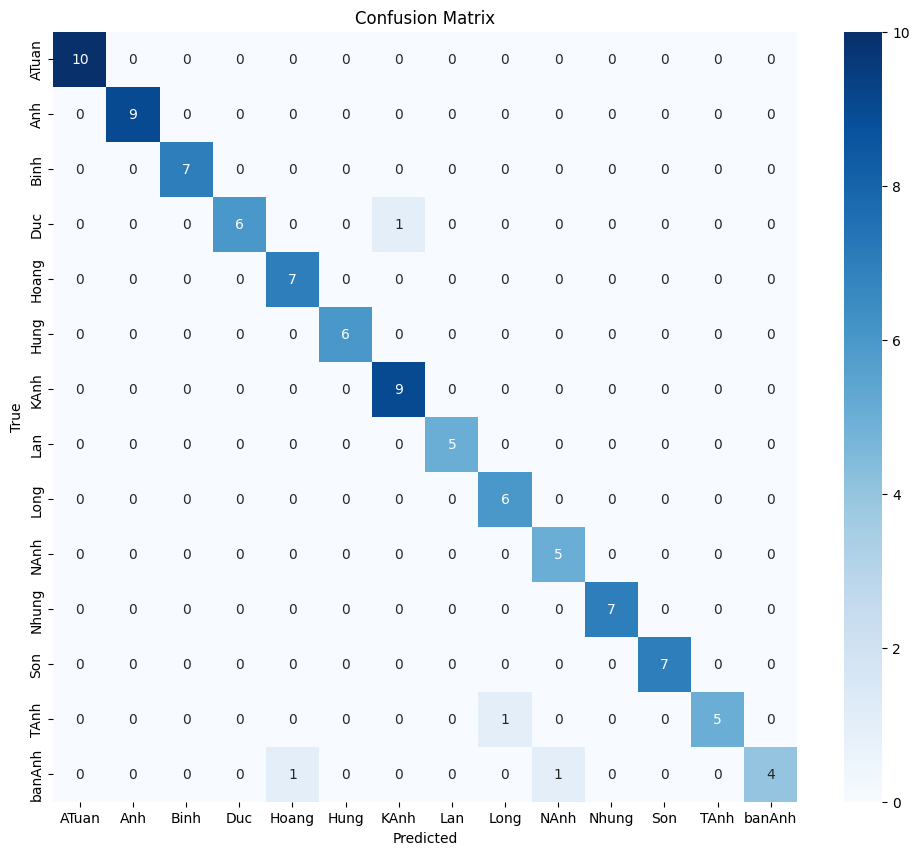

In [74]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hiển thị các kết quả dự đoán

In [75]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [76]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

Output hidden; open in https://colab.research.google.com to view.

Hiển thị các dự đoán sai trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Tìm thấy 4 dự đoán sai. Hiển thị tối đa 4 ví dụ:


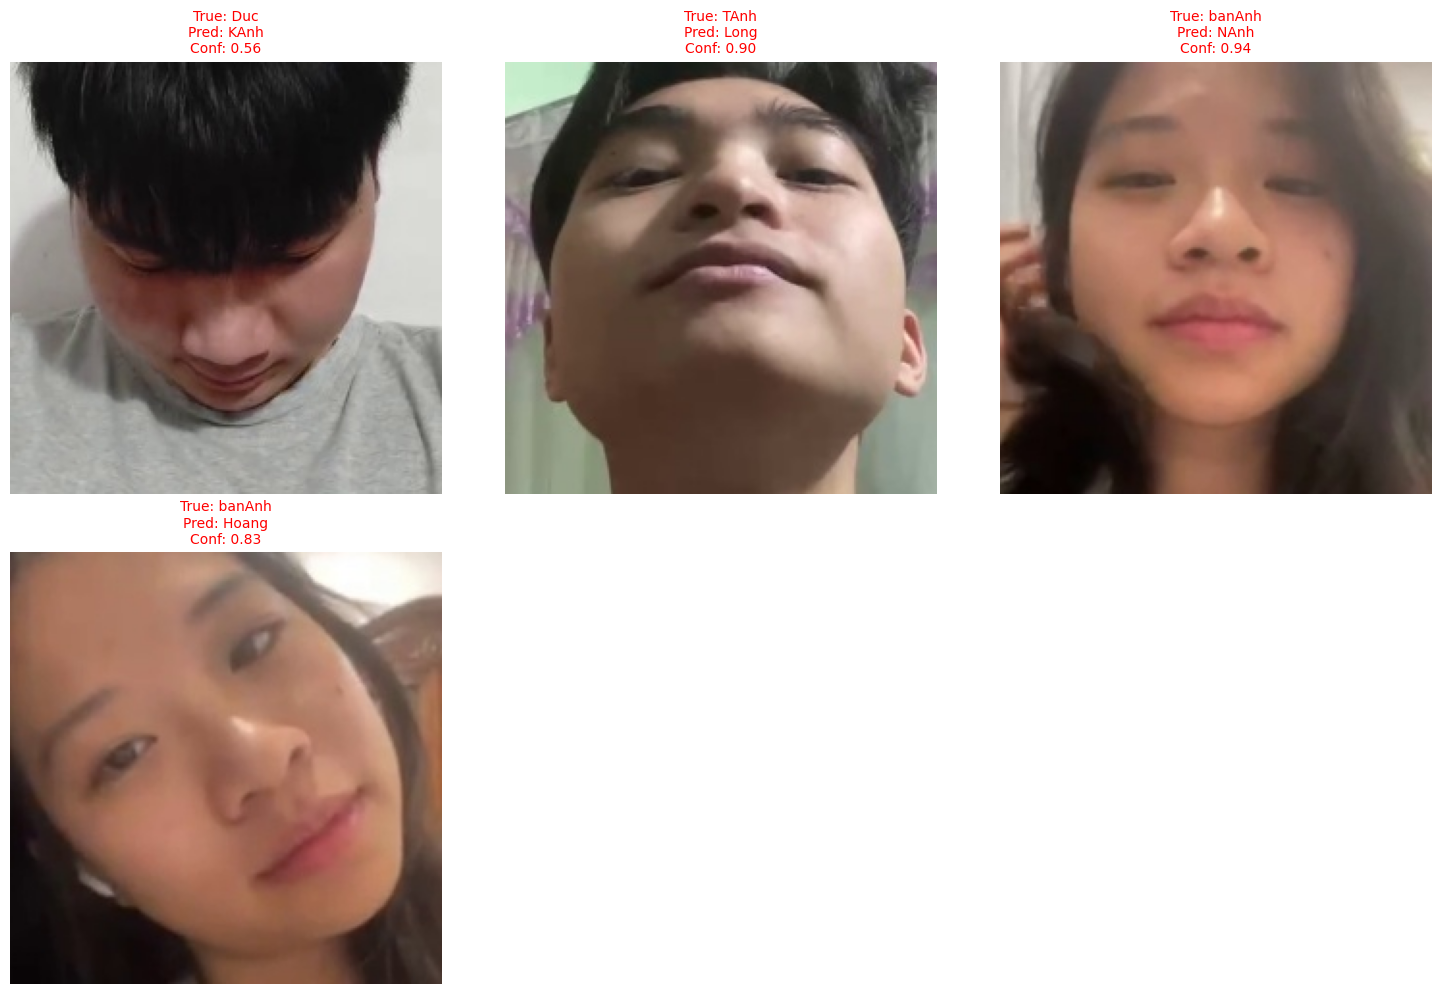

In [77]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

## Vẽ đồ thị quá trình huấn luyện

In [78]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

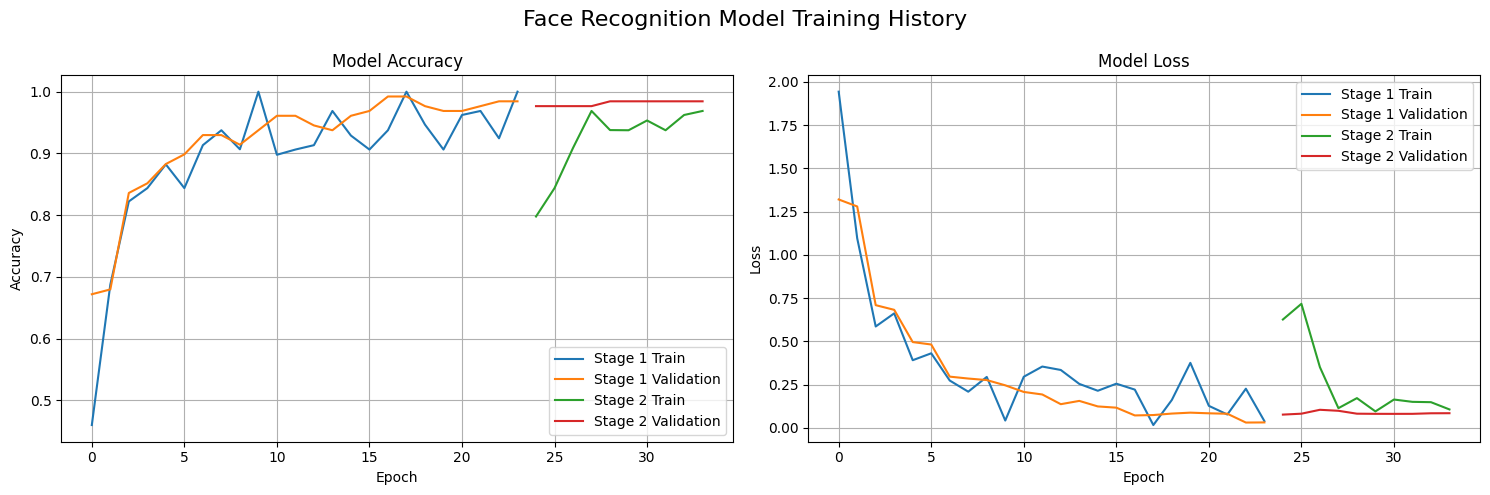

In [79]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [80]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)